# Introduction to Quantum Monte Carlo methods

Monte Carlo methods are extremely powerful tools to deal with problems that have vast phase spaces, such as quantum many-body systems. Here, we will focus on Quantum Monte Carlo (QMC) methods using a specific technique, called Variational Quantum Monte Carlo (VQMC). VQMC is what we find to be the most intuitive and simple, while already allowing us to dive into the depths of QMC methods.

In [ ]:
#hide
import numpy as np
from tqdm.auto import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

## Monte Carlo Integration

The main power of Monte Carlo methods comes from the capability of computing high-dimensional integrals in large spaces. In physics, this allows us to compute expectation values of the form $$\langle f\rangle = \int dx p(x)f(x) \ \ \ \text{or} \ \ \ \langle f \rangle = \sum_{x} p(x)f(x)$$ for continuous and discrete sytems, respectively. 

Physics is benevolent and, generally, the systems of interest only span a tiny bit of their phase space, meaning that $p(x)\simeq 0$ for most states $x$ and, therefore, most of the terms in the previous sum have a meaningless contribution. With Monte Carlo, rather than summing over all the possible states $x$, we approximate the expectation value by sampling from $p(x)$. Hence, $$\langle f \rangle \approx \frac{1}{N}\sum_{i=1}^Nf(x_i),$$ where $x_i$ are sampled according to $p(x)$. This is called importance sampling and it allows us to obtain reasonably good approximations with a limitted amount of samples.

### Energy expectation of a quantum system

In quantum phsyics, a quantity of utmost interest is the expected value of the energy of a system under the action of a Hamiltonian $H$ and a wave function $\Psi(x)$ $$\langle H \rangle = \frac{\langle\Psi^*|H|\Psi\rangle}{\langle \Psi|\Psi\rangle} = \frac{\int dx\Psi^*(x)H\Psi(x)}{\int dx\Psi^*(x)\Psi(x)}.$$

From now on, we will omit the dependency on the state and denote $\Psi\equiv\Psi(x)$ unless needed for clarification. By introducing a term $\frac{\Psi}{\Psi}$ into the numerator, we can rewrite the integral in a convenient way for Monte Carlo integration $$\langle H \rangle = \frac{\int \Psi^*\frac{\Psi}{\Psi}H\Psi}{\int \Psi^*\Psi} = \frac{\int |\Psi|^2 \frac{H\Psi}{\Psi}}{\int |\Psi|^2} = \int \rho E_L,$$
where $\rho=\frac{|\Psi|^2}{\int|\Psi|^2}$ is the probability density and $E_L=\frac{H\Psi}{\Psi}$ is the so called **local energy**. 

Hence, the expected energy can be computed via Monte Carlo integration as the expectation value of the local energy over the probability distribution $\rho=\frac{|\Psi|^2}{\int|\Psi|^2}$, such that $$\langle H\rangle \approx \frac{1}{N}\sum_{k=1}^NE_L(x_k)$$

## Importance Sampling

One of the most important aspects for Monte Carlo integration is the way that importance sampling is done. Markov Chain Monte Carlo (MCMC) is an efficient approach to perform sampling in many dimensions when the probability density $p(x)$ is dominated by a small part of the whole state space. 

Samples are drawn iteratively forming a Markov Chain starting from any given state. In order to properly compute the expected value, the Markov Chain needs to converge to the **stationary distribution** $p(x)$ regardless of the initial state. 

Let $t(x\rightarrow x')$ be the probability to transition from state $x$ to $x'$ such that $\sum_{x'}t(x\rightarrow x')=1$, and $p_s(x)$ the probability to be in state $x$ at step $s$. Then, $p_{s+1}(x) = \sum_{x'}p_s(x')t(x'\rightarrow x)$. A stationary probability is obtained when $p_s(x)$ is independent of the step and, therefore, $$p(x) = \sum_{x'}p(x')t(x'\rightarrow x).$$ 

If a Markov chain is irreducible, the stationary distribution is unique and, if it is also aperiodic, it converges to it. A sufficient condition for stationarity is satsifying the detailed balance condition $p(x)t(x\rightarrow x') = p(x')t(x'\rightarrow x)$.

The **Metropolis-Hastings** algorithm is built to satisfy detailed balance. This is a very simple algorithm in which we split the transition probability $t(x\rightarrow x')$ into two factors: the probability to propose or choose the next state $c(x\rightarrow x')$ and the probability to accept the next state $a(x\rightarrow x')$ such that $$t(x\rightarrow x') = c(x\rightarrow x')a(x\rightarrow x').$$ Detailed balance is fulfilled by taking $a(x\rightarrow x')=\min\left\{1, \frac{p(x')}{p(x)}\frac{c(x'\rightarrow x)}{c(x\rightarrow x')}\right\}$.

Generally, the probability to propose a state is symmetric $c(x\rightarrow x')=c(x'\rightarrow x)$, as it can be, for instance, the case of randomly flipping a spin in a lattice. In these cases, the acceptance probability is simplified $$a(x\rightarrow x') = \min\left\{1, \frac{p(x')}{p(x)}\right\}.$$

A Markov Chain is generated by iterating over the following two steps:
1. With a state $x$, propose a new state $x'$ with probability $c(x\rightarrow x')$
2. Accept $x'$ with probability $a(x\rightarrow x')$. If rejected, the next state is $x$.

The time it takes for the Markov Chain to converge to the stationary distribution is called **thermalisation**. In other words, thermalisation is the time it takes to the Markov Chain to forget its initial state. With MCMC we need to wait for the thermalisation to finish before we can start drawing samples from the desired probability distribution. These samples, though, will be highly correlated between one another, thus requiring careful error analysis to be properly handled. We will deal with this later on.  

### Metropolis-Hastings for quantum problems

As was previously introduced, the expectation value of the energy can be obtained by sampling configurations according to the distribution $\rho=\frac{|\Psi|^2}{\int|\Psi|^2}$. We want the Markov Chain to converge to the stationary distribution $\rho$ and, therefore, the acceptance probabilities need to be defined accordingly $$a(x\rightarrow x') = \min\left\{
1, \frac{\rho(x')}{\rho(x)}\right\} = \min\left\{1, \frac{|\Psi(x')|^2}{|\Psi(x)|^2}\right\}.$$ Notice that the normalisation factor $\int|\Psi|^2$ cancels out. Thus, we never have to worry about normalising probabilities, which would, most times, make the computation intractable.

## Example - Monte Carlo Integration

With this, we have the tools to compute the expectation value of an observable of a quantum many-body system. As an example, we will take the quantum ising model $$H = J\sum_{i=1}^{n-1}\sigma_{i}^z\sigma_{i+1}^z + B\sum_{i=1}^n\sigma_{i}^x,$$ where $\sigma_i^z, \sigma_i^x$ are the Pauli matrices acting on the $i$-th site, without periodic boundary conditions. 

We only need to choose a wave function ansatz. We will take the Restricted Boltzmann Machine (RBM) ansatz of the form $$\Psi(x) = e^{b^Tx}\prod_{i=1}^{n_h}2\cosh(c_i + W_{i\cdot}x),$$ where $b, c, W$ are the visible biases, hidden biases and weight matrix, respectively, and $n_h$ denotes the number of hidden units.  

In [ ]:
class RBM:
    """Super fast and cheap implementation of an RBM with complex weights"""
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        b = np.random.randn(n_visible) + 1j*np.random.randn(n_visible)
        c = np.random.randn(n_hidden) + 1j*np.random.random(n_hidden)
        W = np.random.randn(n_hidden, n_visible) + 1j*np.random.randn(n_hidden,n_visible)
        self.params = np.concatenate((b, c, W.ravel())) / 10
        
    @property
    def b(self): return self.params[:self.n_visible]
    
    @property
    def c(self): return self.params[self.n_visible:self.n_visible+self.n_hidden]
    
    @property
    def W(self): return np.reshape(self.params[self.n_visible+self.n_hidden:], (self.n_hidden, self.n_visible))

    def P(self, v):
        """Probability amplitude of a visible state `v`"""
        return np.exp(np.conj(self.b) @ v)*np.prod(np.cosh(self.c + self.W @ v))
    
    def Pratio(self, v1, v2):
        """Probability ratio between states - `v2` is the numerator. 
        `v2` must be a list of states and `v1` is a reference state."""
        f1 = np.cosh(self.c + self.W @ v1)
        ratios = []
        for v in v2:
            f2 = np.cosh(self.c + self.W @ v)
            log_diff = np.conj(self.b) @ (v-v1) + sum(np.log(f2/f1))
            ratios.append(np.exp(log_diff))
        return ratios 

Let us define the physical system by choosing the number of spins, the coefficients of the Hamiltonian and the parameters of our wave function. Provided that we need a trial wave function, we simply take a set of random parameters for our RBM ansatz. 

In [ ]:
N = 10 # Number of spins
J, B = -2, -1
n_visible, n_hidden = N, 2*N
np.random.seed(7)
psi = RBM(n_visible, n_hidden)

With this, we define some functions to make our code more readable. 

In [ ]:
def local_energy(x, psi):
    # Ising term
    couplings = (x[:-1]==x[1:])*2-1
    e_ising = J*sum(couplings)

    # Transverse field
    states_with_flip = [flip(x, i) for i in range(len(x))]
    e_field = B*sum(psi.Pratio(x, states_with_flip))
    return e_ising + e_field 
    
def flip(x, i):
    "flips i-th bit of x"
    xflip = deepcopy(x)
    xflip[i] = 1-xflip[i]
    return xflip

And now we are ready to do the Monte Carlo integration. We need to choose the total amount of samples to draw `n_samples` and the amount of spin flips `n_flips` performed to propose a configuration. 

In [ ]:
n_samples = 50000
n_flips = 1
state = np.random.randint(0, 2, N)
states = []
energies = []
acceptance = 0
for k in tqdm(range(n_samples)):
    # Sample new state
    idx = np.random.randint(0, psi.n_visible, n_flips)
    new_state = flip(state, idx)

    if np.random.random() <= np.abs(psi.Pratio(state, [new_state]))**2:
        state = deepcopy(new_state)   # Accept new state
        acceptance += 1/n_samples
    states.append(state)
    energies.append(np.real(local_energy(state, psi)))

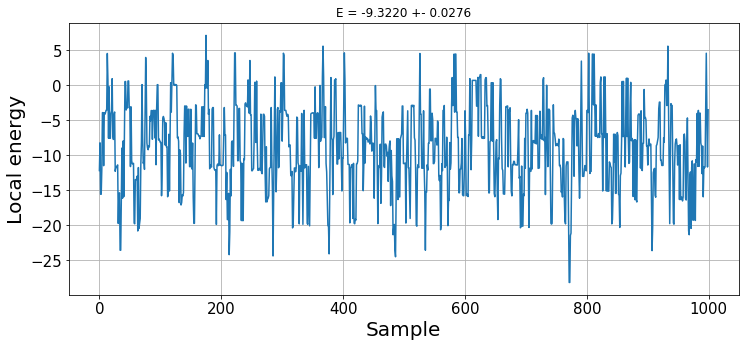

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(energies[:1000])
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel("Local energy", fontsize=20)
plt.xlabel("Sample", fontsize=20)
plt.title(f"E = {np.mean(energies):.4f} +- {np.std(energies)/np.sqrt(n_samples):.4f}");

With a random wave function, we do not observe any thermalisation.

## Statistical analysis and autocorrelation time

Because of the nature of Markov chains, measurements are always correlated. Given that new states are obtained by modifying the previous ones, consecutive states can be highly correlated. Therefore, it is important that we determine the autocorrelation time $\tau$ after which we can consider two samples to be uncorrelated.

The statistical error is obtained via $$\epsilon = \sqrt{\frac{s_f^2}{N}}, \ s_f^2 = \frac{1}{N-1}\sum_{i=1}^N\left(f(X_i) - \langle f \rangle\right)^2.$$ These quantities, however, are well defined for uncorrelated samples. Hence, knowing the autocorrelation time $\tau$, we can compute our estimation values by measuring exclusively every $\tau$ samples. 

### Binning analysis

Knowing the autocorrelation time is extremely important. However, finding the autocorrelation function is too costful and difficult to analyse so, in practice, we rely in the binning analysis of the time series to estimate both $\tau$ and $\epsilon$. The main idea is that averages over parts of the time-series, which are longer than the autocorrelation time, are independent of each other, thus providing the right error estimates. 

Provided that we do not have any prior knowledge about the autocorrelation time, we have to use blocks of increasing lengths until the error estimate converges. We cut the time series into $N_B$ blocks of fixed length $k$ for several values of $k=2^0,2^1, 2^2, \dots$ With this, we can compute the block average of the $i$-th block $$\langle f \rangle_{B_i}=\frac{1}{k}\sum_{t=1}^kf(x_{(i-1)k+t}).$$ All the blocks have a mean $$\langle f\rangle_B = \frac{1}{N_B}\sum_{i=1}^{N_B}\langle f\rangle_{B_i},$$ which, when the block length $k$ is larger than the autocorrelation time $\tau$, allows us to compute the squared statistical error $$\epsilon^2\approx\frac{s_B^2}{N_B}=\frac{1}{N_B(N_B-1)}\sum_{i=1}^{N_B}\left(\langle f\rangle_{B_i} - \langle f\rangle_B\right)^2.$$ If the blocks are independent, $\frac{s_B^2}{N_B}$ remains constant for increasing values of $k$, although for large $k$ (low $N_B\sim100$) statistical fluctuations emerge.

The integrated autocorrelation time can be infered from the binning analysis results. Being  $$\tau=\frac{1}{2}\frac{\frac{s_B^2}{N_B}(k\rightarrow \infty)}{\frac{s_B^2}{N_B}(k=1)}.$$ Bear in mind that the autocorrelation time can **change between quantities**.  

## Example - Binning analysis

Let us continue with our example and perform the binning analysis in order to properly infer the error and the autocorrelation time out of the Markov Chain that we have already generated. 

In [ ]:
def bin_averages(x, bs):
    "Bins time-series `x` into `bs` chunks and takes means"
    Nb = len(x)//bs
    bin_avg = [np.mean(x[b*bs:(b+1)*bs]) for b in range(Nb)]
    return np.array(bin_avg)

In [ ]:
ks = [2**k for k in range(12)]
errors = []
means = []
bin_avgs = []
for k in ks:
    bin_avg = bin_averages(energies, k)
    error = np.sqrt(np.var(bin_avg)/len(bin_avg))
    errors.append(error)
    means.append(bin_avg.mean())
    bin_avgs.append(bin_avg)

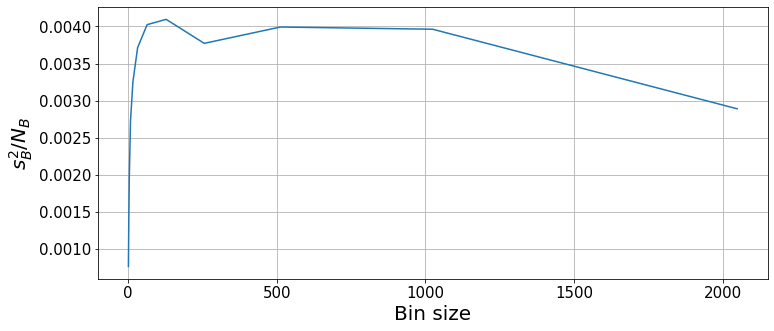

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(ks, np.array(errors)**2)
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel(r"$s_B^2/N_B$", fontsize=20)
plt.xlabel("Bin size", fontsize=20);

With the binning analysis, we see that the squared error has converged. For very large bin sizes, the low number of bins incurs some statistical fluctuations. Thus we will take the result at bin size 1000 to provide a better measure of the energy. 

In [ ]:
print(f"{means[-2]:.4f} +- {errors[-2]:.4f} for k={ks[-2]}")

-9.3176 +- 0.0630 for k=1024


As shown before, we can also use this results to infer the autocorrelation time.

In [ ]:
tau = (errors[-2]/errors[0])**2; tau

5.204697855490824

Let us see the bin averages with the mean and statistical error.

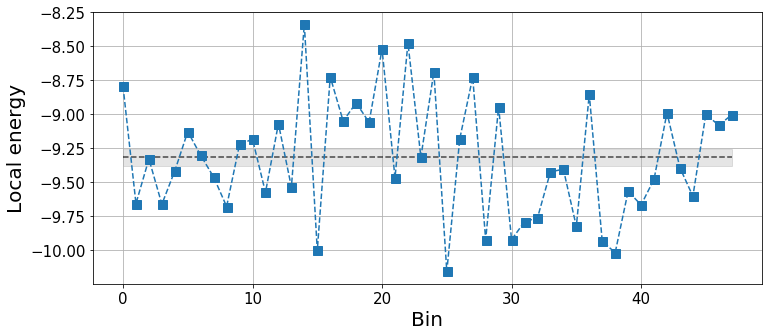

In [ ]:
bins = np.arange(len(bin_avgs[-2]))
plt.figure(figsize=(12, 5))
plt.plot(bins, bin_avgs[-2], 's--', ms=9)
plt.hlines(means[-2], bins[0], bins[-1], linestyles='--', alpha=0.7)
plt.fill_between(bins, means[-2]-errors[-2], means[-2]+errors[-2], color='k', alpha=0.1)
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel("Local energy", fontsize=20)
plt.xlabel("Bin", fontsize=20);

## Monte Carlo optimization

Being able to reliably compute expectation values, we can use the same methods to optimize our variational ansatz according to a target function. In the previous example, we have taken a completely random wave function, which is to be the starting point of an optimization process. 

In QVMC, we use the **stochastic reconfiguration** (SR) method to optimize the parameters of the ansatz via natural gradient. Let our parametrized wavefunction be $\Psi_\theta$, with SR the parameter update rule is $\theta_{t+1}=\theta_t + \alpha S_t^{-1}F_t$, where $\alpha$ is the learning rate, $S$ is an estimation of the Fischer information matrix and $F$ is an estimation of the gradient of the cost function. 

Let us define the variational derivatives $O$ with respect to the $k$-th parameter of our variational ansatz as the log-derivative of the wave function 
$$O_k(x) = \frac{\partial}{\partial\theta_k}\log\left(\Psi_\theta(x)\right)=\frac{1}{\Psi_\theta(x)}\frac{\partial\Psi_\theta(x)}{\partial\theta_k}$$ 
With this, we can define $S$ as the covariance matrix of the variational derivatives and compute $F$ in terms of the previously introduced local energy $E_L(x)$:
$$\begin{align} 
S_{kk'}&=\langle O_k^*O_{k'}\rangle-\langle O_k^*\rangle\langle O_{k'}\rangle \\
F_k&= \langle E_LO_k^*\rangle - \langle E_L\rangle\langle O_k^*\rangle
\end{align}$$
As an extra step, there can be introduced a regularization term to increase the learning stability by rescaling the diagonal terms of $S$ such that $S_{kk} = S_{kk}(1+\lambda)$. 

## Example -- Monte Carlo optimization

Let us put everything together to find the ground state energy of the Ising Hamiltonian used in the previous examples. For the case of an RBM ansatz, the variational derivatives of the parameters can be obtained pretty easily, being: 
$$\begin{align}
O_{b_j}(s) &= \frac{\partial}{\partial b_j}\log\left(\Psi(s)\right) = s_j \\
O_{c_i}(s) &= \frac{\partial}{\partial c_i}\log\left(\Psi(s)\right) = \tanh\left[\theta_i(s)\right] \\
O_{W_{ij}}(s) &= \frac{\partial}{\partial W_{ij}}\log\left(\Psi(s)\right) = s_j\tanh\left[\theta_i(s)\right]
\end{align}$$
Where $\theta_i(s)$ is the argument of the hyperbolic cosine $\theta_i(s) = c_i + \sum_j W_{ij}s_j$.

In [ ]:
def variational_derivative(x, psi):
    "Computes variational derivatives for SR"
    theta = psi.c + psi.W @ x
    Ob = x
    Oc = np.tanh(theta)
    Ow = Oc[:, None] @ x[None, :]
    return np.concatenate((Ob, Oc, Ow.ravel()))

def sample_batch(psi, bs, x0=None, n_flips=1):
    "Samples a batch of states"
    state = np.random.randint(0, 2, psi.n_visible) if x0 is None else x0
    states = []
    for _ in range(bs):
        idx = np.random.randint(0, psi.n_visible, n_flips)
        new_state = flip(state, idx)

        if np.random.random() <= np.abs(psi.Pratio(state, [new_state]))**2:
            state = deepcopy(new_state)   # Accept new state   
        states.append(state)
    return states

def covariance(x1, x2=None):
    "Computes the covariance between `x1` and `x2`."
    samples = x1.shape[1]
    m1 = np.mean(x1, axis=1)
    if x2 is not None:
        if len(x2.shape)>1: m2 = np.mean(x2, axis=1)
        else: m2 = np.mean(x2)
    else:
        x2, m2 = x1, m1
        
    return (x1 @ x2.T)/samples - m1[:,None] @ m2[None,:]

In [ ]:
learning_iterations = 275
lr = 1e-2
n_blocks = 150
thermalise = int(0.1*n_blocks)
Nb = n_blocks - thermalise
bs = N
n_flips = 1
energies = []

for it in tqdm(range(learning_iterations)):
    EL, O = np.zeros(Nb, dtype=complex), np.zeros((len(psi.params), Nb), dtype=complex)
    states = sample_batch(psi, thermalise*bs, n_flips=n_flips)
    state = states[-1]
    for k in range(Nb):
        batch = sample_batch(psi, bs, x0=state, n_flips=n_flips)
        states += batch
        state = batch[-1]
        EL[k] = local_energy(state, psi)
        O[:, k] = variational_derivative(state, psi)
    
    energies.append(EL.mean())
    F = covariance(O.conj(), EL[None,:])      # Gradient
    Sinv = covariance(O.conj(), O)            # Fisher info
    Sinv = np.linalg.pinv(Sinv, rcond=1e-5)  # Inversion
    d_params = lr*Sinv @ F
    psi.params -= d_params.squeeze()

Let us plot the expected energy over the optimization steps.

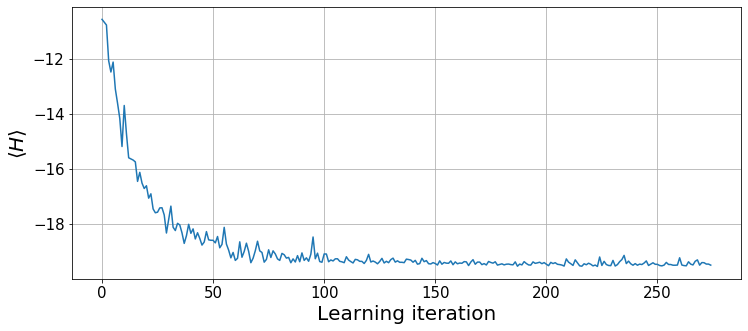

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(np.real(energies))
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel(r"$\langle H\rangle$", fontsize=20)
plt.xlabel("Learning iteration", fontsize=20);

We observe that the algorithm has converged at around 150 iterations. Let's see what are the local energies sampled at the last optimization step.

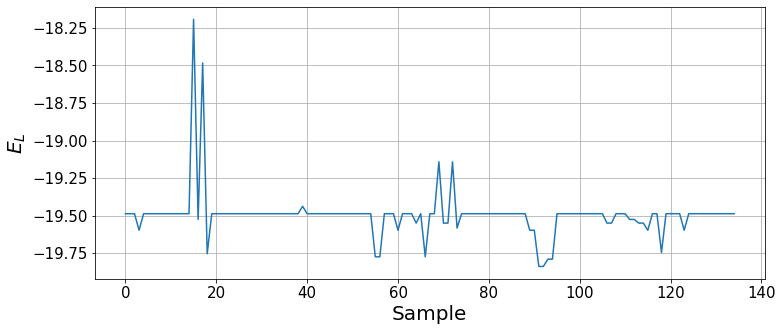

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(np.real(EL))
plt.grid()
plt.tick_params(labelsize=15)
plt.ylabel(r"$E_L$", fontsize=20)
plt.xlabel("Sample", fontsize=20);

We can see how, by the end of the optimization, the wavefunction mainly provides the ground state and, with some small probability, other states are sampled. To report the ground state energy, we take the result of the last 100 optimization steps analogously to the binning analysis (the imaginary part should average to zero).   

In [ ]:
bins = 100
energy = np.mean(np.real(energies[-bins:]))
statistical_error = np.std(energies[-bins:])/np.sqrt(bins)
print(f"The obtained energy is {energy:.4f}+-{statistical_error:.4f}")

The obtained energy is -19.4404+-0.0093


Notice that we have taken the quantum Ising model in the ferromagnetic phase. Therefore, the ground state is found when all spins are aligned. 

In [ ]:
print(f"The ground state is {state}")

The ground state is [0 0 0 0 0 0 0 0 0 0]


We can compare this with exact diagonalization, provided that we are solving a small system, in order to see the actual real error. Let us build the Hamiltonian matrix and diagonlaize it. 

In [ ]:
def tensor_prod(idx, s, size=10):
    "Tensor product of `s` acting on indexes `idx`. Fills rest with Id."
    Id = np.array([[1,0],[0,1]])
    idx, s = np.array(idx), np.array(s)
    matrices = [Id if k not in idx else s for k in range(size)]
    prod = matrices[0]
    for k in range(1, size):
        prod = np.kron(prod, matrices[k])
    return prod

sx = np.array([[0,1],[1,0]])
sz = np.array([[1,0],[0,-1]])
    
H = J*sum([tensor_prod([k, k+1], sz, size=N) for k in range(N-1)]) + B*sum([tensor_prod(k, sx, size=N) for k in range(N)])
e_vals, e_vecs = np.linalg.eigh(H)

In [ ]:
relative_error = np.abs((energy-e_vals[0])/e_vals[0])
print(f"The exact ground state energy is {e_vals[0]:.4f}")
print(f"Relative error between variational energy {energy:.4f} and exact solution {e_vals[0]:.4f}: {relative_error*100:.4f}%")

The exact ground state energy is -19.5310
Relative error between variational energy -19.4404 and exact solution -19.5310: 0.4640%
